# TODO:

Try:

* Different models:
  * Sarsa Linear (done)
  * Sarsa ANN (done)
  * Q-learning Linear?
  * Q-learning ANN without experience replay
  * Q-learning ANN with experience replay
  * Q-learning ANN with experience replay and policy/target network split?
* Different loss functions:
  * MSE -> leads to updates as in Sutton, Barto
  * SmoothL1?
  * What do they use in DQN paper?

In [1]:
import sys
sys.path.append("..")
from rl_utils import *
from cart_pole import *

# Settings

In [2]:
ENVIRONMENT_ID = "CartPole-v1"
NUM_EPISODES = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch device:", device)

PyTorch device: cuda


# Sarsa

## Linear model

Average return per episode: 18.333


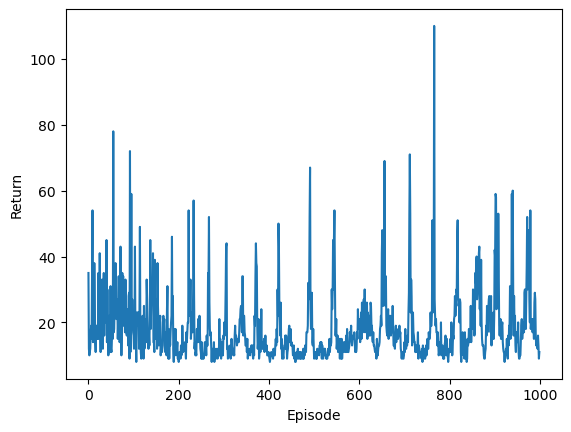

In [3]:
env = gym.make(ENVIRONMENT_ID)
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_sarsa(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

## Simple Neural Network

In [ ]:
env = gym.make(ENVIRONMENT_ID)
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, env.action_space.n)
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_sarsa(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

# Q-learning

## Linear model

In [ ]:
env = gym.make(ENVIRONMENT_ID)
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_qlearning(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

## Simple Neural Network

In [ ]:
env = gym.make(ENVIRONMENT_ID)
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, env.action_space.n)
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_qlearning(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

# Q-learning with experience replay

## Linear Model

In [ ]:
def train_episodic_semi_gradient_qlearning_experience_replay(env, model, loss_func, optimizer, device, num_episodes, memory_size):
    eps = 1
    returns = []
    replay_memory = ReplayMemory(memory_size)
    for ep in range(num_episodes):
        observation, info = env.reset()
        truncated = False
        terminated = False
        G = 0

        while not (terminated or truncated):
            action = select_action_eps_greedy(env, model, torch.tensor(observation, device=device), eps)
            next_observation, reward, terminated, truncated, info = env.step(action)
            replay_memory.store(observation, action, reward, next_observation)
            G += reward

            if terminated:
                
            else:
                observation = next_observation

        eps = update_eps(eps)
        returns.append(G)
    return returns

In [ ]:
replay_memory = ReplayMemory(2)
replay_memory.store(torch.tensor((0, 0, 0, 0), dtype=torch.float32, device=device).unsqueeze(0), 0, 0, torch.tensor((1, 1, 1, 1), dtype=torch.float32, device=device).unsqueeze(0))
replay_memory.store(torch.tensor((2, 2, 2, 2), dtype=torch.float32, device=device).unsqueeze(0), 1, 1, torch.tensor((3, 3, 3, 3), dtype=torch.float32, device=device).unsqueeze(0))
replay_memory.store(torch.tensor((4, 4, 4, 4), dtype=torch.float32, device=device).unsqueeze(0), 2, 2, torch.tensor((5, 5, 5, 5), dtype=torch.float32, device=device).unsqueeze(0))
state_batch, action_batch, reward_batch, next_state_batch = replay_memory.sample_batch(2)
print("state_batch")
print(state_batch)
print("action_batch")
print(action_batch)
print("reward_batch")
print(reward_batch)
print("next_state_batch")
print(next_state_batch)

In [ ]:
torch.cat(state_batch)

In [ ]:
model(torch.cat(state_batch))

In [21]:
env = gym.make(ENVIRONMENT_ID)
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
memory_size = 4
batch_size = 3
replay_memory = ReplayMemory(memory_size)
observation, info = env.reset()
state = torch.tensor(observation, device=device).unsqueeze(0)
for i in range(3):
    action = select_action_eps_greedy(env, model, state, 1)
    observation, reward, terminated, truncated, info = env.step(action)
    next_state = torch.tensor(observation, device=device).unsqueeze(0)
    action = torch.tensor(action, device=device).unsqueeze(0)
    reward = torch.tensor(reward, device=device).unsqueeze(0)
    # For testing
    if i == 1:
        terminated = True
    replay_memory.store(state, action, reward, None if terminated else next_state)
    if len(replay_memory) >= batch_size:
        state_batch, action_batch, reward_batch, next_state_batch = replay_memory.sample_batch(batch_size)
        state_batch = torch.cat(state_batch)
        action_batch = torch.cat(action_batch)
        reward_batch = torch.cat(reward_batch)
        non_terminal_next_states_mask = torch.tensor([s != None for s in next_state_batch], device=device)
        non_terminal_next_states = torch.cat([s for s in next_state_batch if s is not None])
        max_estimated_next_values = torch.zeros(batch_size, device=device)
        with torch.no_grad():
            print(model(non_terminal_next_states))
            print(torch.max(model(non_terminal_next_states), dim=1).values)
            max_estimated_next_values[non_terminal_next_states_mask] = torch.max(model(non_terminal_next_states), dim=1).values
        print("--------------------")
        print(state_batch)
        print(action_batch)
        print(reward_batch)
        print(next_state_batch)
        print(non_terminal_next_states_mask)
        print(non_terminal_next_states)
        print(max_estimated_next_values)
    state = next_state
env.close()

tensor([[ 0.5306, -0.5997],
        [ 0.3762, -0.3783]], device='cuda:0')
tensor([0.5306, 0.3762], device='cuda:0')
--------------------
tensor([[ 0.0488, -0.1776,  0.0150,  0.3177],
        [ 0.0484,  0.0177,  0.0146,  0.0205],
        [ 0.0452,  0.0173,  0.0214,  0.0298]], device='cuda:0')
tensor([1, 0, 1], device='cuda:0')
tensor([1., 1., 1.], device='cuda:0')
(None, tensor([[ 0.0488, -0.1776,  0.0150,  0.3177]], device='cuda:0'), tensor([[ 0.0456,  0.2121,  0.0220, -0.2560]], device='cuda:0'))
tensor([False,  True,  True], device='cuda:0')
tensor([[ 0.0488, -0.1776,  0.0150,  0.3177],
        [ 0.0456,  0.2121,  0.0220, -0.2560]], device='cuda:0')
tensor([0.0000, 0.5306, 0.3762], device='cuda:0')
